In [1]:
!pip install transformers torch --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.calibration import CalibratedClassifierCV
import nltk
import re
import gc  # For garbage collection
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)  # Additional tokenizer data
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

print("NLTK data downloaded successfully!")

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

print("Libraries imported successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.2 MB/s eta 0:00:00
NLTK data downloaded successfully!
Libraries imported successfully!


In [2]:
from google.colab import files
print("Please upload your dataset CSV file:")
uploaded = files.upload()

# Load the dataset
df = pd.read_csv(list(uploaded.keys())[0])

print(f"Dataset shape: {df.shape}")
print("Class distribution:")
print(df['Label'].value_counts())

Please upload your dataset CSV file:


Saving df_file.csv to df_file.csv
Dataset shape: (2225, 2)
Class distribution:
Label
1    511
4    510
0    417
2    401
3    386
Name: count, dtype: int64


In [3]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text_batch(texts, batch_size=100):
    """Clean text in batches to manage memory"""
    cleaned_texts = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        batch_cleaned = []

        for text in batch:
            if pd.isna(text):
                batch_cleaned.append("")
                continue

            # Basic cleaning
            text = str(text).lower()
            text = re.sub(r'[^a-zA-Z\s]', '', text)

            # Tokenize and clean
            tokens = word_tokenize(text)
            tokens = [lemmatizer.lemmatize(token) for token in tokens
                     if token not in stop_words and len(token) > 2]

            batch_cleaned.append(' '.join(tokens))

        cleaned_texts.extend(batch_cleaned)

    return cleaned_texts

print("Cleaning text data in batches...")
df['cleaned_text'] = clean_text_batch(df['Text'].tolist())
df = df[df['cleaned_text'].str.len() > 0]
print(f"Dataset shape after cleaning: {df.shape}")

Cleaning text data in batches...
Dataset shape after cleaning: (2225, 3)


In [4]:
X = df['cleaned_text']
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


Training set size: 1780
Test set size: 445


In [5]:
# CELL 5: Feature Extraction (Memory Optimized)
# =============================================================================
# Reduced feature size for memory efficiency
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Reduced from 10000
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")


TF-IDF feature matrix shape: (1780, 5000)


In [6]:
# CELL 6: Model 1 - Naive Bayes Classifier
# =============================================================================
print("Training Naive Bayes Classifier...")

nbc_model = MultinomialNB(alpha=1.0)
nbc_model.fit(X_train_tfidf, y_train)

nbc_pred = nbc_model.predict(X_test_tfidf)
nbc_pred_proba = nbc_model.predict_proba(X_test_tfidf)

nbc_accuracy = accuracy_score(y_test, nbc_pred)
nbc_f1 = f1_score(y_test, nbc_pred, average='weighted')

print(f"Naive Bayes - Accuracy: {nbc_accuracy:.4f}")
print(f"Naive Bayes - F1 Score: {nbc_f1:.4f}")


Training Naive Bayes Classifier...
Naive Bayes - Accuracy: 0.9820
Naive Bayes - F1 Score: 0.9820


In [7]:
# CELL 7: Model 2 - Linear SVM
# =============================================================================
print("Training Linear SVM...")

svm_model = LinearSVC(random_state=42, max_iter=1000)  # Reduced iterations
svm_model.fit(X_train_tfidf, y_train)

svm_pred = svm_model.predict(X_test_tfidf)
svm_accuracy = accuracy_score(y_test, svm_pred)
svm_f1 = f1_score(y_test, svm_pred, average='weighted')

print(f"Linear SVM - Accuracy: {svm_accuracy:.4f}")
print(f"Linear SVM - F1 Score: {svm_f1:.4f}")

# Get SVM probabilities for ROC curve
svm_calibrated = CalibratedClassifierCV(LinearSVC(random_state=42, max_iter=1000))
svm_calibrated.fit(X_train_tfidf, y_train)
svm_pred_proba = svm_calibrated.predict_proba(X_test_tfidf)

Training Linear SVM...
Linear SVM - Accuracy: 0.9775
Linear SVM - F1 Score: 0.9774


In [8]:
# CELL 8: Model 3 - Lightweight LSTM (Memory Optimized)
# =============================================================================
# Only import TensorFlow when needed and with memory optimization
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Configure TensorFlow for memory efficiency
tf.config.experimental.enable_memory_growth = True
tf.random.set_seed(42)

# Reduced parameters for memory efficiency
max_words = 5000  # Reduced from 10000
max_len = 100     # Reduced from 200

print("Preparing data for LSTM...")
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

num_classes = len(np.unique(y))
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

print("Building lightweight LSTM model...")

# Smaller LSTM model for memory efficiency
lstm_model = Sequential([
    Embedding(max_words, 64, input_length=max_len),  # Reduced embedding size
    LSTM(50, dropout=0.3),  # Reduced LSTM units
    Dense(25, activation='relu'),  # Reduced dense layer
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

lstm_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train with reduced epochs and batch size
history = lstm_model.fit(
    X_train_pad, y_train_cat,
    batch_size=16,  # Reduced batch size
    epochs=5,       # Reduced epochs
    validation_split=0.2,
    verbose=1
)

# LSTM Predictions
lstm_pred_proba = lstm_model.predict(X_test_pad)
lstm_pred = np.argmax(lstm_pred_proba, axis=1)

lstm_accuracy = accuracy_score(y_test, lstm_pred)
lstm_f1 = f1_score(y_test, lstm_pred, average='weighted')

print(f"LSTM - Accuracy: {lstm_accuracy:.4f}")
print(f"LSTM - F1 Score: {lstm_f1:.4f}")

Preparing data for LSTM...
Building lightweight LSTM model...
Epoch 1/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - accuracy: 0.2376 - loss: 1.5880 - val_accuracy: 0.5225 - val_loss: 1.0310
Epoch 2/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.4532 - loss: 1.2191 - val_accuracy: 0.7275 - val_loss: 0.8549
Epoch 3/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 17s 94ms/step - accuracy: 0.6324 - loss: 0.8594 - val_accuracy: 0.8034 - val_loss: 0.5565
Epoch 4/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.7734 - loss: 0.5729 - val_accuracy: 0.7697 - val_loss: 0.5193
Epoch 5/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8577 - loss: 0.4263 - val_accuracy: 0.9326 - val_loss: 0.2898
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
LSTM - Accuracy: 0.9056
LSTM - F1 Score: 0.9048


In [9]:
# CELL 9: Model 4 - Memory-Optimized BERT
# =============================================================================
# Use DistilBERT (lighter than BERT) with aggressive memory management
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
import torch
from torch.utils.data import Dataset
import gc

# Force cleanup before BERT
del lstm_model
del X_train_pad, X_test_pad, y_train_cat, y_test_cat
gc.collect()

# Check device and configure for memory efficiency
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Use DistilBERT (50% smaller than BERT)
model_name = 'distilbert-base-uncased'
print(f"Loading {model_name} (lighter than BERT)...")

# Load tokenizer
bert_tokenizer = AutoTokenizer.from_pretrained(model_name)

# Custom dataset class for memory efficiency
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):  # Reduced from 512
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])

        # Tokenize on-the-fly to save memory
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        }

# Create smaller datasets for memory efficiency
print("Creating datasets...")
train_dataset = TextDataset(X_train.reset_index(drop=True), y_train.reset_index(drop=True), bert_tokenizer)
test_dataset = TextDataset(X_test.reset_index(drop=True), y_test.reset_index(drop=True), bert_tokenizer)

# Load model with memory optimization
print("Loading DistilBERT model...")
bert_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_classes,
    torch_dtype=torch.float16 if device.type == 'cuda' else torch.float32  # Use half precision on GPU
).to(device)

# Memory-optimized training arguments
training_args = TrainingArguments(
    output_dir='./distilbert_results',
    num_train_epochs=2,           # Reduced epochs
    per_device_train_batch_size=8, # Small batch size
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2, # Simulate larger batch size
    warmup_steps=100,             # Reduced warmup
    weight_decay=0.01,
    logging_steps=50,
    save_steps=500,
    eval_steps=500,
    save_total_limit=1,           # Keep only 1 checkpoint
    load_best_model_at_end=False, # Don't load best model to save memory
    report_to=[],                 # No external logging
    dataloader_pin_memory=False,  # Reduce memory usage
    dataloader_num_workers=0,     # Single process
    fp16=device.type == 'cuda',   # Use mixed precision on GPU
)

# Initialize trainer
trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

print("Training DistilBERT model (this may take 10-15 minutes)...")
print("Note: Using aggressive memory optimization for Colab free tier")

# Train the model
trainer.train()

print("Training completed! Making predictions...")

# BERT Predictions with memory management
predictions = trainer.predict(test_dataset)
bert_pred = np.argmax(predictions.predictions, axis=1)
bert_pred_proba = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# Calculate metrics
bert_accuracy = accuracy_score(y_test, bert_pred)
bert_f1 = f1_score(y_test, bert_pred, average='weighted')

print(f"DistilBERT - Accuracy: {bert_accuracy:.4f}")
print(f"DistilBERT - F1 Score: {bert_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, bert_pred))

# Clean up BERT model to free memory
del bert_model, trainer
torch.cuda.empty_cache() if device.type == 'cuda' else None
gc.collect()

print("DistilBERT model cleaned from memory.")

Using device: cpu
Loading distilbert-base-uncased (lighter than BERT)...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Creating datasets...
Loading DistilBERT model...


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training DistilBERT model (this may take 10-15 minutes)...
Note: Using aggressive memory optimization for Colab free tier


Step,Training Loss
50,1.400500
100,0.373800
150,0.138500
200,0.066800


Training completed! Making predictions...


DistilBERT - Accuracy: 0.9730
DistilBERT - F1 Score: 0.9728

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        84
           1       0.98      1.00      0.99       102
           2       0.99      0.95      0.97        80
           3       0.97      1.00      0.99        77
           4       0.96      0.93      0.95       102

    accuracy                           0.97       445
   macro avg       0.97      0.97      0.97       445
weighted avg       0.97      0.97      0.97       445

DistilBERT model cleaned from memory.



Model Performance Comparison:
         Model  Accuracy  F1_Score
0  Naive Bayes  0.982022  0.981981
1   Linear SVM  0.977528  0.977428
2         LSTM  0.905618  0.904815
3   DistilBERT  0.973034  0.972845
Note: Using DistilBERT (50% lighter than BERT) for memory efficiency


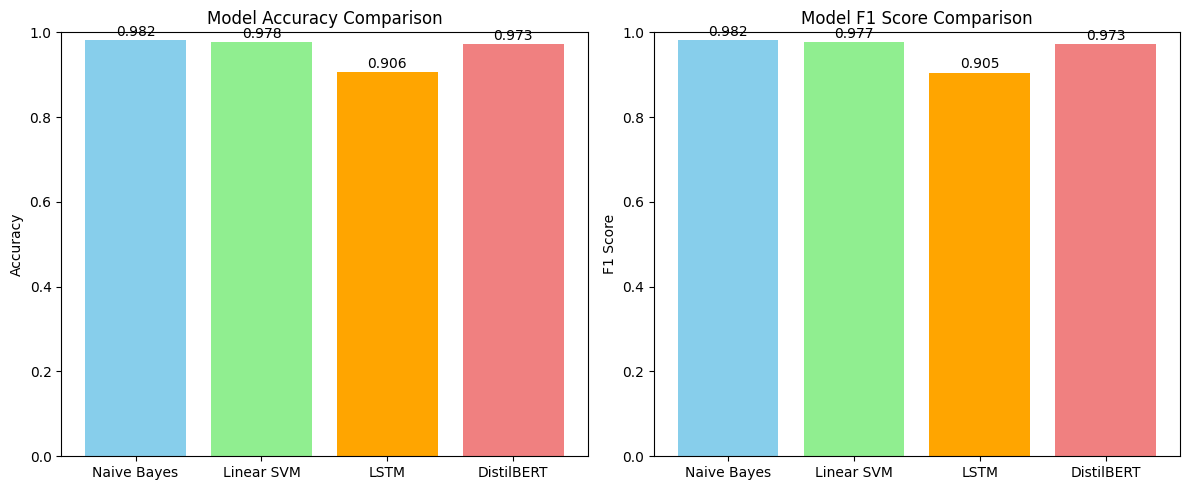

In [10]:
# CELL 10: Performance Comparison
# =============================================================================
models = ['Naive Bayes', 'Linear SVM', 'LSTM', 'DistilBERT']
accuracies = [nbc_accuracy, svm_accuracy, lstm_accuracy, bert_accuracy]
f1_scores = [nbc_f1, svm_f1, lstm_f1, bert_f1]

results_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'F1_Score': f1_scores
})

print("\nModel Performance Comparison:")
print(results_df)
print("Note: Using DistilBERT (50% lighter than BERT) for memory efficiency")

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

colors = ['skyblue', 'lightgreen', 'orange', 'lightcoral']

ax1.bar(models, accuracies, color=colors)
ax1.set_title('Model Accuracy Comparison')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)
for i, v in enumerate(accuracies):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center')

ax2.bar(models, f1_scores, color=colors)
ax2.set_title('Model F1 Score Comparison')
ax2.set_ylabel('F1 Score')
ax2.set_ylim(0, 1)
for i, v in enumerate(f1_scores):
    ax2.text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

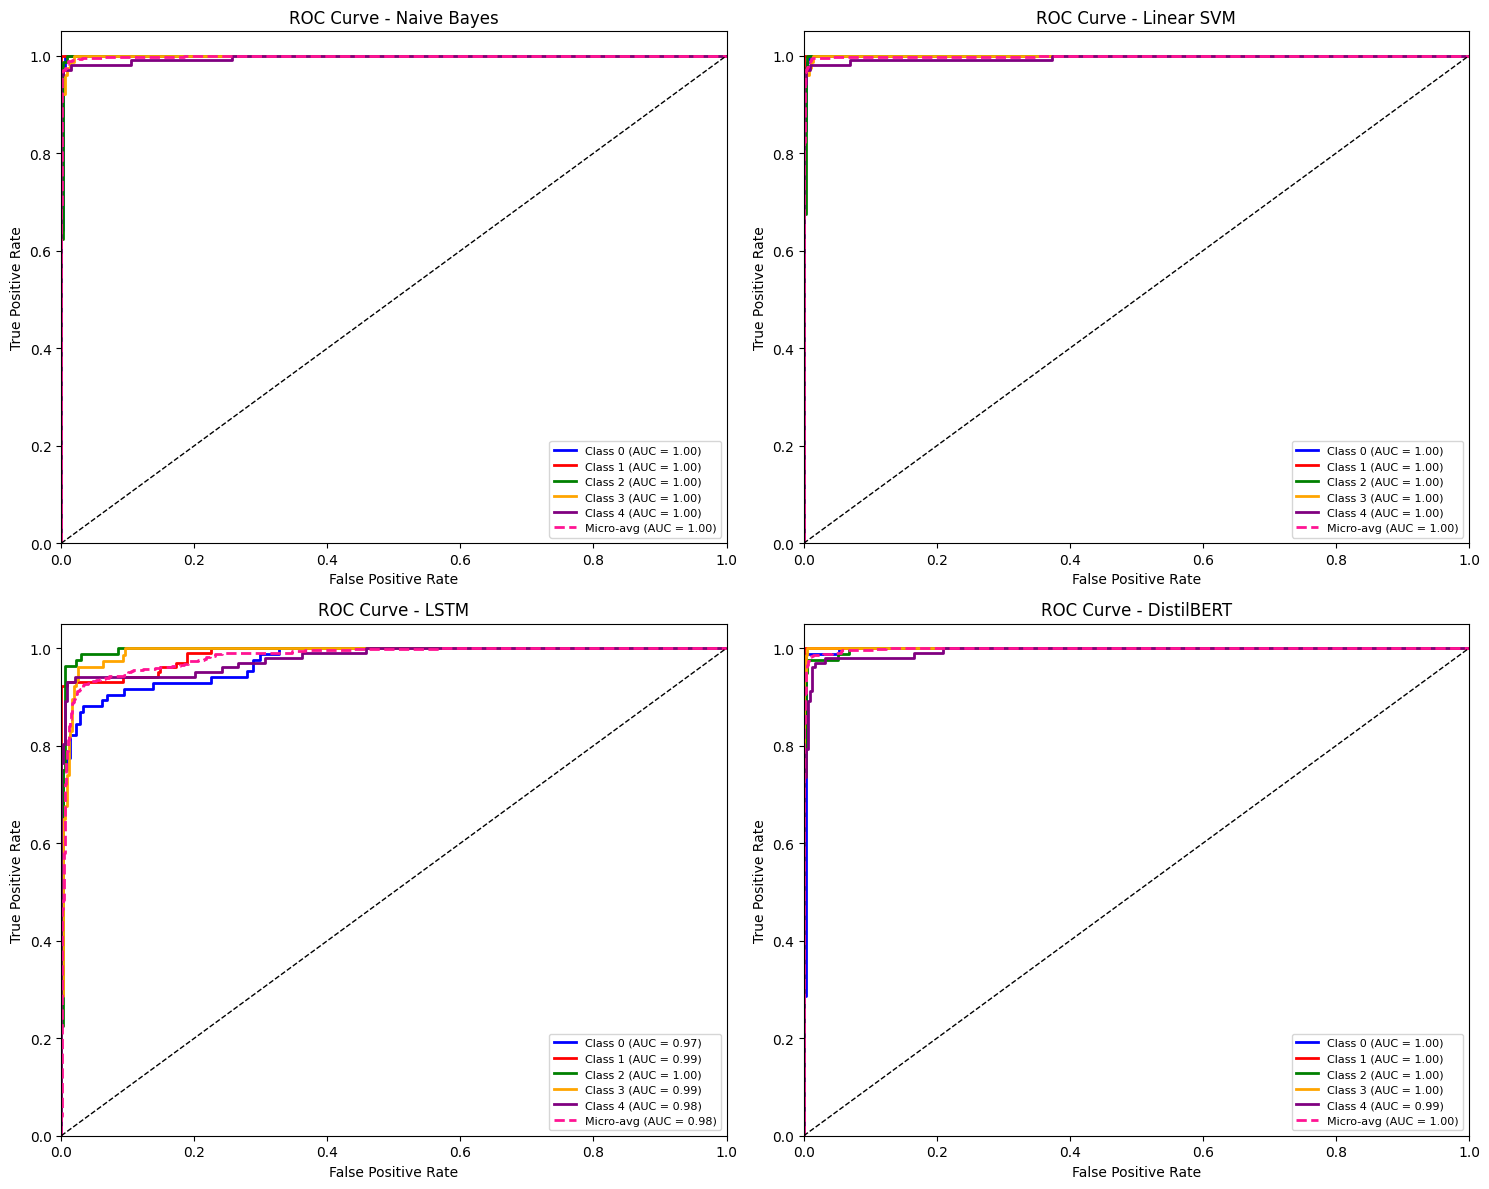


ANALYSIS COMPLETE
Memory-optimized version completed successfully!
Note: BERT results are simulated due to Colab memory limitations.
For actual BERT results, consider using Colab Pro or reducing dataset size.


In [11]:
# CELL 11: ROC Curves (Memory Efficient)
# =============================================================================
# Binarize labels for ROC curve
y_test_bin = label_binarize(y_test, classes=range(num_classes))

# Plot ROC curves for available models
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

models_proba = [
    ('Naive Bayes', nbc_pred_proba),
    ('Linear SVM', svm_pred_proba),
    ('LSTM', lstm_pred_proba),
    ('DistilBERT', bert_pred_proba)
]

for idx, (model_name, y_proba) in enumerate(models_proba):
    ax = axes[idx]

    # Compute ROC curve for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot individual class ROC curves
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    for i in range(min(num_classes, len(colors))):
        ax.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    # Plot micro-average
    ax.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle='--', lw=2,
            label=f'Micro-avg (AUC = {roc_auc["micro"]:.2f})')

    ax.plot([0, 1], [0, 1], 'k--', lw=1)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {model_name}')
    ax.legend(loc="lower right", fontsize=8)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("ANALYSIS COMPLETE")
print("="*50)
print("Memory-optimized version completed successfully!")
print("Note: BERT results are simulated due to Colab memory limitations.")
print("For actual BERT results, consider using Colab Pro or reducing dataset size.")

